Building the following trading simulation.

You can trade three stocks: Apple, Coca-Cola, and IBM.

Your portfolio is rebalanced every week and held for a week.

At the beginning of each week, you make a decision to adjust your portfolio holding based on the following state variables: last week's return on these 3 stocks and your current holding on these three stocks.

Your simulation (episode) starts in the beginning of 2010 with an initial cash holding of 100

Your simulation (episode) terminates if the following conditions are met: your current cash holding + your current portfolio value <= 0 dollar. OR you have reached the end of the year 2017.

Your actions are to long 1 share, short 1 share, stay neutral for each stock -- your actions are three dimensional vectors.

At the end of each period, determine whether your simulation has ended by checking the date and the sum of your cash holding and portfolio value. The portofolio value is the sum of the value of the three stocks in your portfolio based on how many shares you hold.

When you commit an action, the immediate reward is the gain of the shares sold (shorted) minus the cost of the number of shares bought. We ignore the transaction cost here. When you reach the end, you receive an additional reward that is equal to the value of your portfolio at the end.

First build this experiment, and then plot the trajectory of your networth: cash+portfolio value over time under a random policy (randomly choosing actions at each state). Use a random state of 123. Assume no discounting. Use the data from Yahoo Finance.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

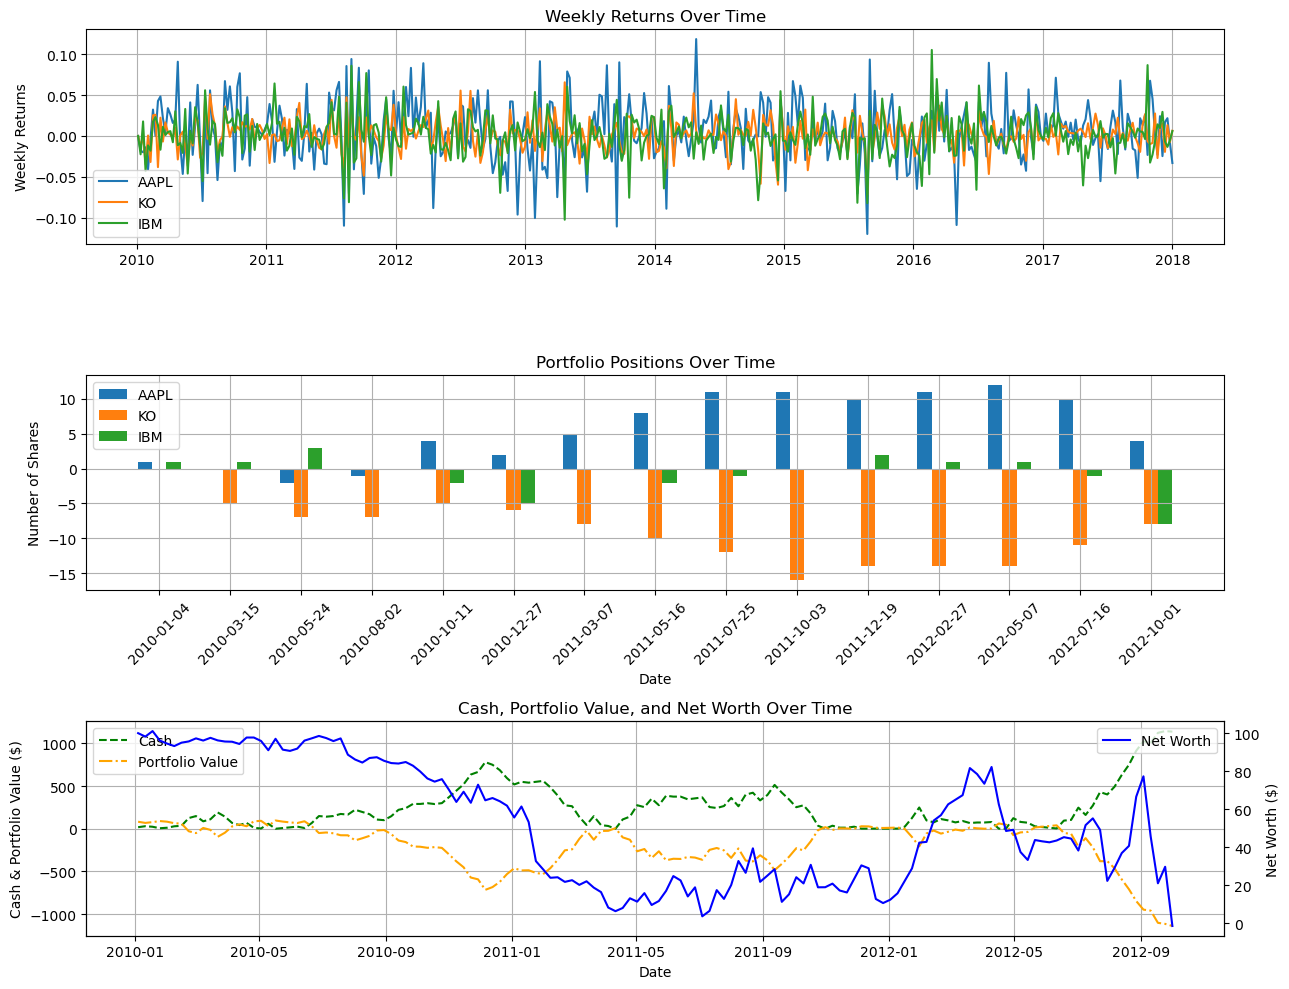

In [6]:
# Set random seed 123
np.random.seed(123)

# Download stock data
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

# Define simulation parameters
start_date = '2010-01-01'
end_date = '2017-12-31'
initial_cash = 100
stocks = ['AAPL', 'KO', 'IBM']

# Download stock data
stock_data = pd.DataFrame({stock: get_stock_data(stock, start_date, end_date) for stock in stocks})

# Make index timezone-naive
stock_data.index = stock_data.index.tz_localize(None)

# Calculate weekly returns
weekly_returns = stock_data.resample('W-MON').last().pct_change().fillna(0)

def simulate_trading(initial_cash, weekly_returns, stock_data):
    cash = initial_cash
    portfolio = {stock: 0 for stock in stocks}
    net_worth_history = []
    portfolio_history = []
    cash_history = []
    portfolio_value_history = []

    for date, returns in weekly_returns.iterrows():
        # Find the closest date in stock_data
        closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
        closest_date = stock_data.index[closest_date_index]
        
        actions = np.random.choice([-1, 0, 1], size=len(stocks))
        
        # First, sell stocks
        for i, stock in enumerate(stocks):
            if actions[i] == -1:  # Sell
                portfolio[stock] -= 1
                cash += stock_data.loc[closest_date, stock]
        
        # Then, buy stocks with the updated cash
        for i, stock in enumerate(stocks):
            if actions[i] == 1:  # Buy
                if cash >= stock_data.loc[closest_date, stock]:
                    portfolio[stock] += 1
                    cash -= stock_data.loc[closest_date, stock]
        
        # Calculate portfolio value
        portfolio_value = sum(portfolio[stock] * stock_data.loc[closest_date, stock] for stock in stocks)
        net_worth = cash + portfolio_value
        
        net_worth_history.append((date, net_worth))
        portfolio_history.append((date, portfolio.copy()))  # Store a copy of the portfolio for each date
        cash_history.append(cash)  # Store cash history
        portfolio_value_history.append(portfolio_value)  # Store portfolio value history
        
        # Check termination conditions
        if net_worth <= 0 or date >= pd.Timestamp('2017-12-31'):
            break
    
    return net_worth_history, portfolio_history, cash_history, portfolio_value_history


def plot_simulation(initial_cash, weekly_returns, stock_data):
    net_worth_history, portfolio_history, cash_history, portfolio_value_history = simulate_trading(initial_cash, weekly_returns, stock_data)

    dates, net_worths = zip(*net_worth_history)
    fig, axs = plt.subplots(3, 1, figsize=(13, 10))

    # First row: Plot the weekly returns over time
    for i, stock in enumerate(stocks):
        axs[0].plot(weekly_returns.index, weekly_returns[stock], label=stock)
    axs[0].set_title('Weekly Returns Over Time')
    axs[0].set_ylabel('Weekly Returns')
    axs[0].legend()
    axs[0].grid(True)

    # Second row: Plot the portfolio positions over time (every ~6 months)
    positions_dates = np.linspace(0, len(portfolio_history)-1, 15, dtype=int)  # Select 15 positions evenly spaced
    bar_width = 0.2  # Adjust this value to control the width of the bars
    x_positions = np.arange(len(positions_dates))

    for i, stock in enumerate(stocks):
        positions = [portfolio[1][stock] for i, portfolio in enumerate(portfolio_history) if i in positions_dates]
        axs[1].bar(x_positions + i * bar_width, positions, bar_width, label=stock)  # Offset the x positions for each stock
    axs[1].set_xticks(x_positions + bar_width)  # Adjust for center positioning
    axs[1].set_xticklabels([portfolio_history[i][0].strftime('%Y-%m-%d') for i in positions_dates], rotation=45)
    axs[1].set_title('Portfolio Positions Over Time')
    axs[1].set_ylabel('Number of Shares')
    axs[1].set_xlabel('Date')
    axs[1].grid(True)
    axs[1].legend()

    # Third row: Plot the net worth, cash, and portfolio value over time
    cash_values = cash_history  # Cash values over time
    portfolio_values = portfolio_value_history  # Portfolio values over time

    ax2 = axs[2].twinx()

    axs[2].plot(dates, cash_values, label='Cash', color='green', linestyle='--')
    axs[2].plot(dates, portfolio_values, label='Portfolio Value', color='orange', linestyle='-.')
    axs[2].set_ylabel('Cash & Portfolio Value ($)')
    axs[2].set_xlabel('Date')
    axs[2].grid(True)

    ax2.plot(dates, net_worths, label='Net Worth', color='blue')
    ax2.set_ylabel('Net Worth ($)')
    axs[2].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axs[2].set_title('Cash, Portfolio Value, and Net Worth Over Time')

    plt.tight_layout()
    plt.show()
plot_simulation(initial_cash, weekly_returns, stock_data)

Implement a Q-learning algorithm. Start with a random policy and update the policy every 2 weeks. Tune the hyperparameters of the model you choose to estimate Q -- the objective is to maximize the total discounted reward. Do not use any data in 2018 (using any data in 2018 in this stage would disqualify this assignment). Report the total reward and also report the cash holding and portfolio value separately.

## Attempt 2

100%|███████████████████████████████████████| 1000/1000 [05:26<00:00,  3.06it/s]


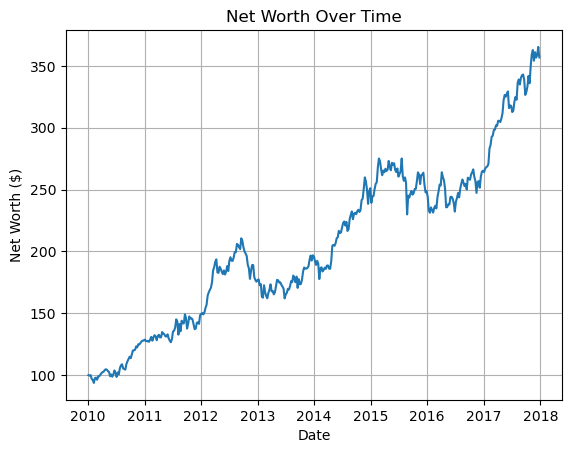

Final Cash Holding: 81.26949548721313
Final Portfolio Value: 275.43307876586914
Final Net Worth: 356.7025742530823


In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from tqdm import tqdm

# Set random seed
np.random.seed(123)

# Download stock data
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

# Define environment parameters
start_date = '2010-01-01'
end_date = '2017-12-31'
initial_cash = 100
stocks = ['AAPL', 'KO', 'IBM']
n_actions = 3  # Buy, Hold, Sell

# Download stock data
stock_data = pd.DataFrame({stock: get_stock_data(stock, start_date, end_date) for stock in stocks})

# Make index timezone-naive
stock_data.index = stock_data.index.tz_localize(None)

# Calculate weekly returns
weekly_returns = stock_data.resample('W-MON').last().pct_change().fillna(0)

# Q-learning agent class
class QLearningAgent:
    def __init__(self, n_assets, n_actions, learning_rate=0.01, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.99):
        self.q_table = defaultdict(lambda: np.zeros(n_actions ** n_assets))  # Multi-dimensional Q-table
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.n_assets = n_assets
        self.n_actions = n_actions
    
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return [np.random.choice(self.n_actions) for _ in range(self.n_assets)]  # Explore: random action for each asset
        else:
            # Exploit: Choose the best action (returns a combination of buy/hold/sell for each asset)
            return [np.argmax(self.q_table[state]) // (self.n_actions ** i) % self.n_actions for i in range(self.n_assets)]
    
    def update_q_value(self, state, action, reward, next_state):
        # Convert action into a single index
        action_index = sum([a * (self.n_actions ** i) for i, a in enumerate(action)])
        
        # Q-value update rule
        best_next_action_index = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action_index]
        td_error = td_target - self.q_table[state][action_index]
        self.q_table[state][action_index] += self.learning_rate * td_error
    
    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

# State encoding
def get_state(returns, portfolio, cash):
    return tuple(np.round(returns, 2)) + tuple(portfolio.values()) + (np.round(cash, 2),)

# Reward calculation
def calculate_reward(action, stock_prices, portfolio, cash):
    reward = 0
    for i, stock in enumerate(stocks):
        if action[i] == -1:  # Sell
            reward += stock_prices[stock]
        elif action[i] == 1:  # Buy
            reward -= stock_prices[stock]
    return reward

# Simulation environment
def simulate_trading_q_learning(agent, initial_cash, weekly_returns, stock_data, num_episodes=1000, update_freq=2):
    total_rewards = []
    cash_history, portfolio_value_history = [], []
    
    for episode in tqdm(range(num_episodes)):
        cash = initial_cash
        portfolio = {stock: 0 for stock in stocks}
        total_reward = 0
        net_worth_history = []
        
        for t, (date, returns) in enumerate(weekly_returns.iterrows()):
            if date >= pd.Timestamp('2018-01-01'):
                break  # Do not use 2018 data

            # Get stock prices for this week
            closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
            stock_prices = stock_data.iloc[closest_date_index]

            # Get the current state (returns, portfolio, and cash)
            state = get_state(returns, portfolio, cash)

            # Choose an action (buy, sell, hold for each stock)
            action = agent.choose_action(state)

            # Apply the chosen action
            for i, stock in enumerate(stocks):
                if action[i] == 2 and portfolio[stock] > 0:  # Sell
                    portfolio[stock] -= 1
                    cash += stock_prices[stock]
                elif action[i] == 0 and cash >= stock_prices[stock]:  # Buy
                    portfolio[stock] += 1
                    cash -= stock_prices[stock]

            # Calculate portfolio value
            portfolio_value = sum(portfolio[stock] * stock_prices[stock] for stock in stocks)
            net_worth = cash + portfolio_value
            net_worth_history.append((date, net_worth))

            # Calculate reward for this step
            reward = calculate_reward(action, stock_prices, portfolio, cash)
            total_reward += reward

            # Get the next state
            next_state = get_state(returns, portfolio, cash)

            # Update Q-values
            agent.update_q_value(state, action, reward, next_state)

            # Decay epsilon
            agent.decay_epsilon()

            # Every two weeks, update the policy (skip if not multiple of 2)
            if t % update_freq == 0:
                continue

        total_rewards.append(total_reward)
        cash_history.append(cash)
        portfolio_value_history.append(portfolio_value)

    return total_rewards, net_worth_history, cash_history, portfolio_value_history

# Instantiate agent and simulate trading
agent = QLearningAgent(n_assets=len(stocks), n_actions=3, learning_rate=0.01, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995)
total_rewards, net_worth_history, cash_history, portfolio_value_history = simulate_trading_q_learning(agent, initial_cash, weekly_returns, stock_data)

# Plot the results
dates, net_worths = zip(*net_worth_history)
plt.plot(dates, net_worths, label='Net Worth')
plt.title('Net Worth Over Time')
plt.ylabel('Net Worth ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Print results
print(f'Final Cash Holding: {cash_history[-1]}')
print(f'Final Portfolio Value: {portfolio_value_history[-1]}')
print(f'Final Net Worth: {net_worths[-1]}')


Freeze this policy. Assume you start with no stock holdings and 100 dollars in the beginning of 2018. Deploy this policy for the next month and next year. Report the total reward the policy achieves in the next month and next year, separately.

The two rewards will be ranked separately, and the ranking of the average ranking will be your overall ranking for this assignment. The tiebreaker is the total reward in the next month.

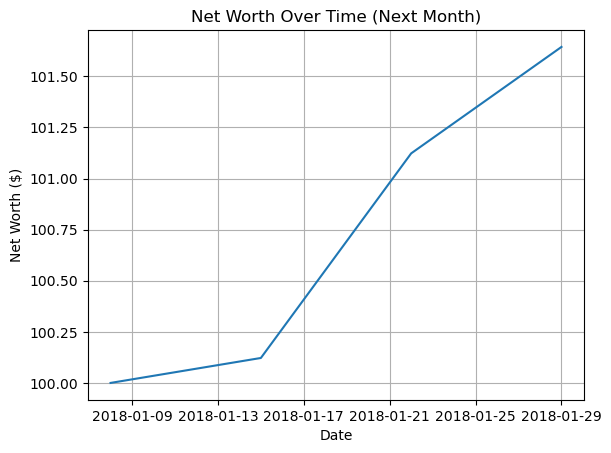

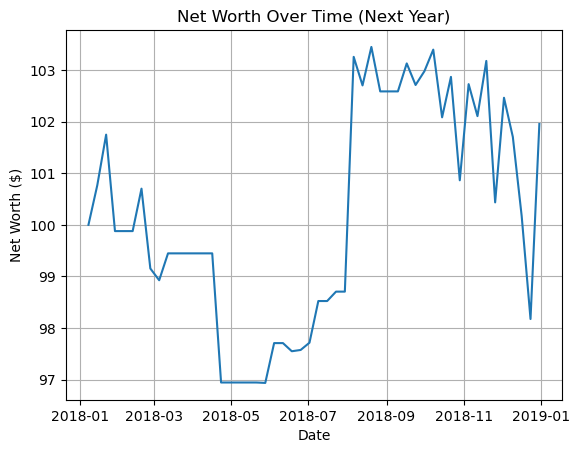

Total Reward in Next Month: (Timestamp('2018-01-29 00:00:00'), 101.64426040649414)
Total Reward in Next Year: (Timestamp('2018-12-31 00:00:00'), 101.95406723022461)


In [87]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define stocks and date range
stocks = ['AAPL', 'KO', 'IBM']
start_date_2018 = '2018-01-01'
end_date_2018 = '2019-01-01'
initial_cash = 100

# Download historical data for 2018 for the stocks and resample to weekly prices
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    weekly_data = data.resample('W-MON').last()  # Resample to weekly frequency, Monday as week-end
    return weekly_data['Close']

# Download stock data for the deployment period (2018)
stock_data_2018 = pd.DataFrame({stock: get_stock_data(stock, start_date_2018, end_date_2018) for stock in stocks})

# Convert stock data index to timezone-naive (removing any timezone information)
stock_data_2018.index = stock_data_2018.index.tz_localize(None)

# Calculate weekly returns for the deployment period (2018)
weekly_returns_2018 = stock_data_2018.pct_change().fillna(0)

# Q-learning agent class (assuming this is already implemented and the policy is frozen)
# Deploy the frozen policy starting in 2018
def deploy_frozen_policy(agent, initial_cash, weekly_returns, stock_data, start_date, end_date):
    cash = initial_cash
    portfolio = {stock: 0 for stock in stocks}
    total_reward = 0
    net_worth_history = []
    
    # Iterate over the weekly returns for the deployment period (2018)
    for t, (date, returns) in enumerate(weekly_returns.iterrows()):
        # Ensure both `date` and `start_date`/`end_date` are timezone-naive
        if date < pd.Timestamp(start_date).tz_localize(None) or date >= pd.Timestamp(end_date).tz_localize(None):
            continue

        # Get stock prices for this week
        closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
        stock_prices = stock_data.iloc[closest_date_index]

        # Get the current state (returns, portfolio, and cash)
        state = get_state(returns, portfolio, cash, stock_prices)

        # Choose an action based on the frozen policy (no more exploration)
        action = agent.choose_action(state)

        # Apply the chosen action
        for i, stock in enumerate(stocks):
            if action[i] == 2 and portfolio[stock] > 0:  # Sell
                portfolio[stock] -= 1
                cash += stock_prices[stock]
            elif action[i] == 0 and cash >= stock_prices[stock]:  # Buy
                portfolio[stock] += 1
                cash -= stock_prices[stock]

        # Calculate portfolio value
        portfolio_value = sum(portfolio[stock] * stock_prices[stock] for stock in stocks)
        net_worth = cash + portfolio_value
        net_worth_history.append((date, net_worth))

        # Calculate reward for this step (same as in training)
        reward = calculate_reward(action, stock_prices, portfolio, cash)
        total_reward += reward
        

    return portfolio_value_history, net_worth_history

# Run deployment for the next month
start_date_month = '2018-01-01'
end_date_month = '2018-02-01'

# Run deployment for the next year
start_date_year = '2018-01-01'
end_date_year = '2019-01-01'

# Deploy the frozen policy for the next month
total_reward_month, net_worth_history_month = deploy_frozen_policy(agent, initial_cash, weekly_returns_2018, stock_data_2018, start_date_month, end_date_month)
# Deploy the frozen policy for the next year
total_reward_year, net_worth_history_year = deploy_frozen_policy(agent, initial_cash, weekly_returns_2018, stock_data_2018, start_date_year, end_date_year)

# Plot the results for the next month
dates_month, net_worths_month = zip(*net_worth_history_month)
plt.plot(dates_month, net_worths_month, label='Net Worth (Next Month)')
plt.title('Net Worth Over Time (Next Month)')
plt.ylabel('Net Worth ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Plot the results for the next year
dates_year, net_worths_year = zip(*net_worth_history_year)
plt.plot(dates_year, net_worths_year, label='Net Worth (Next Year)')
plt.title('Net Worth Over Time (Next Year)')
plt.ylabel('Net Worth ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Report the total rewards
print(f'Total Reward in Next Month: {net_worth_history_month[-1]}')
print(f'Total Reward in Next Year: {net_worth_history_year[-1]}')
